In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import itertools
import math
import numpy
import copy

In [4]:
# Return the average in-degree of the given graph
def averageInDegree(G):
    # sum of the degrees of all its nodes divided by the number of nodes in the graph
    degreeSum = 0
    for node in G.nodes: 
        degreeSum += (G.in_degree[node])
    
    # divide by number of nodes to normalize
    return degreeSum/len(G.nodes)

In [5]:
# Compute User Activity for the given node in network 
def UserActivity(G,node_num):
    return (G.in_degree[node_num]*random.random())/(len(G.nodes))

In [6]:
# Sigmoid scaling function to generate probabiltiies between 0 and 1 
def sigmoid(x):
    return ((2)/(1+math.exp(-x)))-1

In [7]:
# Compute tweet probability (f_u) for all nodes in G 
def compute_tweet_prob(G, TS, UA, scale_factor):
    scale_factor = scale_factor
    w_1 = 0.1
    w_2 = 1-w_1
    
    # compute f_u 
    f = (w_1*TS + w_2*UA)*scale_factor
        
    return f

In [8]:
# Compute IsMentioned variable for given tweeter (node1) and follower (node2)
def isMentioned(G,node1,node2):
    isMentioned = 0
    
    if node2 in list(G.neighbors(node1)) and node2 in list(G.predecessors(node1)):
        isMentioned = 1
        
    # add random factor 
    return isMentioned*random.random()

In [9]:
# Compute pairwise retweet probability (r_u) between the tweeting node (node1) and follower node (node2)
def compute_retweet_prob(G,node1,node2,scale_factor,TS,UA):
    scale_factor = scale_factor
    
    # Compute # common following
    node1_following = set(G.neighbors(node1))
    node2_following = set(G.neighbors(node2))
    
    num_common_following = len(node1_following.intersection(node2_following))
    
    # Compute # common followers
    node1_followers = set(G.predecessors(node1))
    node2_followers = set(G.predecessors(node2))
    
    num_common_followers = len(node1_followers.intersection(node2_followers))

    # Compute Similarity Score 
    w_following = 0.5
    w_followers = 1-w_following 
    
    SS = w_following*num_common_following + w_followers*num_common_followers
    
    # Compute IsMentioned
    IM = isMentioned(G,node1,node2)
    
    # Compute r_u 
    w_SS = 0.4
    w_TS = 0.1
    w_UA = 0.25
    w_IM = 0.25
    
    r_u = scale_factor*(w_SS*SS + w_TS*TS + w_UA*UA + w_IM*IM)
    
    return r_u

In [10]:
# Compute what the total sum of both in-degrees/out-degrees should be based on edge probability, p
def total_degree_sum(p, num_nodes):
    return p*(num_nodes**2)

In [11]:
import numpy as np 
# Create a degree distribution based on the total number of nodes and total in-degree/out-degree sum
def createRandomDist(numNodes, average, totalDegSum):
    degrees = []
    out_degrees = []
    
    in_degrees = np.random.dirichlet(np.ones(numNodes-1),size=1)[0]
    out_degrees = np.random.dirichlet(np.ones(numNodes-1),size=1)[0]
    
    in_degrees_final = [int(d*totalDegSum) for d in in_degrees]
    out_degrees_final = [int(d*totalDegSum) for d in out_degrees]
    
    # create last value 
    in_deg_sum = sum(in_degrees_final)
    out_deg_sum = sum(out_degrees_final)
    
    diff = in_deg_sum - out_deg_sum 
    
    if diff<0:  # outdeg>indeg
        out_degrees_final.append(0)
        in_degrees_final.append((-1)*diff)
    elif diff>0: # indeg>outeg
        out_degrees_final.append(diff)
        in_degrees_final.append(0)
    else:
        rannum = random.randint(0,300)
        out_degrees_final.append(rannum)
        in_degrees_final.append(rannum)
    
    return in_degrees_final, out_degrees_final


In [12]:
# Modified Forest Fire Algorithm 
# Inputs: graph (G), dictionary of tweet probabilites (f), dictionary of retweet probabilities (r)
# tweet probability threshold (f_0), retweet probability threshold (r_0)
def mff(G, f, r, f_0, r_0):
    S = set()
    N = set()
    fire = [] 
    
    num_spreaders = []
    num_nonspreaders = []
    num_trees = []
    iterations = 0
    status = {}
    checkpoint_frequency = 4
    num_checkpoints = len(G.nodes)/checkpoint_frequency
    
    # 4 checkpoints
    N_checkpoints = []
    
    S_checkpoints = [] 
    
    
    # Initialize statuses of nodes
    for node in G.nodes(): 
        if f[node] >= f_0: 
            status[node] = 1
            fire.append(node)
            S.add(node)
        else: 
            status[node] = 0
    
    # Status Guide
        # 1 : fire
        # 0 : tree
        # -1 : burnt

    # Loop through nodes stil on fire 
    while (len(fire)!=0):
        node = fire.pop()
        
        # Check neighbros of node on fire
        for neighbor in G.predecessors(node):
            if status[neighbor] == 0 or status[neighbor] == -1: 
                if r[(node,neighbor)]>= r_0:
                    status[neighbor] = 1
                    fire.append(neighbor)
                    S.add(neighbor)
                    if neighbor in N: 
                        N.remove(neighbor)
                else: 
                    status[neighbor] = -1
                    N.add(neighbor)
        
            num_spreaders.append(len(S))
            num_nonspreaders.append(len(N))
            num_trees.append(len(G.nodes)-(len(S)+len(N)))
            
            # For visualization at bottom of notebook 
            if (iterations%num_checkpoints==0):
                N_copy = N.copy()
                S_copy = S.copy()

                N_checkpoints.append(N_copy)
                S_checkpoints.append(S_copy)
                
            iterations= iterations + 1
    
    # Final Checkpoint 
    N_copy = N.copy()
    S_copy = S.copy()

    N_checkpoints.append(N_copy)
    S_checkpoints.append(S_copy)
    
    return S,N, num_spreaders, num_nonspreaders, num_trees, iterations, N_checkpoints, S_checkpoints
                

# Run 1

In [35]:
# Defin eGraph 
numNodes = 1000
p = 0.10
averageDeg = numNodes*p
totalDegSum = total_degree_sum(p,numNodes)

degree = createRandomDist(numNodes, averageDeg,totalDegSum)
in_degrees = degree[0]
out_degrees = degree[1]

In [36]:
# NetworkX Function to create graph 
G1 = nx.directed_configuration_model(in_degree_sequence = in_degrees,out_degree_sequence = out_degrees)

In [37]:
# Compute all user activities and topic significance 
UA = {}
for node in G1.nodes: 
    UA[node] = UserActivity(G1,node)
    
TS = 1

In [38]:
# Compute tweet probabilities for every node
f_u_init = {}
f_u_sigmoid_init = {}
scale_factor = 3
for node in G1.nodes: 
    # compute f_u 
    f =  compute_tweet_prob(G1,TS,UA[node],scale_factor)
    f_u_init[node]=f
    f_u_sigmoid_init[node] = sigmoid(f)

In [39]:
# Compute tweet probabilities for every user-follower pair (pair of connected nodes in network)
r_u_init = {}
r_u_sigmoid_init = {}
scale_factor = 1

for node in G1.nodes: 
    # loop through followers
    for follower in G1.predecessors(node):
        r = compute_retweet_prob(G1,node,follower,scale_factor,TS,UA[node])
        r_u_init[(node,follower)] = r
        r_u_sigmoid_init[(node,follower)] = sigmoid(r)


In [40]:
# A helper function to scale the retweet probability called to produce the graphs 
def scale_retweet_probs(scale_factor,r_u_init,r_u_sigmoid_init):
    r_u_scaled = {}
    r_u_sigmoid_scaled = {} 
    
    for node_pair in r_u_init:
        r = scale_factor*r_u_init[node_pair]
        r_u_scaled[node_pair] = r
        r_u_sigmoid_scaled[node_pair] = sigmoid(r)
        
    return r_u_scaled, r_u_sigmoid_scaled

In [41]:
# 0-.25 with iteration of 0.01
scale_factors = list(np.arange(0, 0.25, 0.01))
print((scale_factors))

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24]


In [42]:
p_spreaders = []
p_nonspreaders = []
trees = []

# Loop through scale factors to track the composition of nodes after running MFF with each sf
for sf in scale_factors: 
    
    # regenerate retweet probs
    r_u_scaled, r_u_sigmoid_scaled = scale_retweet_probs(sf, r_u_init, r_u_sigmoid_init)
    
    # not regenerating tweet probabilites, using the same as before 
    
    # Run simulation
    r_0 = 0.5
    f_0 = 0.5
    lists = mff(G1,f_u_sigmoid_init,r_u_sigmoid_scaled,f_0,r_0)
    
    # Save output
    S = lists[0]
    N = lists[1]
    num_S = lists[2]
    num_N = lists[3]
    num_T = lists[4]
    
    N_checkpoints = lists[6]
    S_checkpoints = lists[7]

    iterations = lists[5]
    
    p_s = (num_S[-1])/(numNodes)
    p_ns = (num_N[-1])/(numNodes)
    p_spreaders.append(p_s)
    p_nonspreaders.append(p_ns)
    trees.append(1-(p_s+p_ns))


In [43]:
print(p_spreaders)
print(p_nonspreaders)

[0.014, 0.014, 0.019, 0.073, 0.197, 0.315, 0.43, 0.506, 0.563, 0.623, 0.667, 0.705, 0.733, 0.766, 0.788, 0.808, 0.829, 0.843, 0.85, 0.856, 0.867, 0.872, 0.874, 0.882, 0.889]
[0.845, 0.845, 0.874, 0.871, 0.772, 0.663, 0.552, 0.478, 0.422, 0.364, 0.32, 0.282, 0.254, 0.221, 0.199, 0.179, 0.158, 0.144, 0.137, 0.131, 0.121, 0.116, 0.114, 0.107, 0.1]


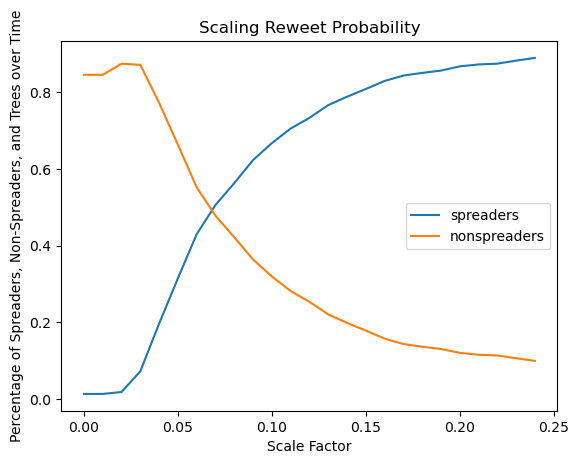

In [44]:
plt.plot(scale_factors,p_spreaders, label="spreaders")
plt.plot(scale_factors,p_nonspreaders, label="nonspreaders")
# plt.plot(scale_factors,trees, label="trees")

plt.xlabel('Title')
plt.ylabel('Percentage of Spreaders, Non-Spreaders, and Trees over Time')
plt.xlabel('Scale Factor')
plt.title('Scaling Reweet Probability')
plt.legend()
plt.show()

In [45]:
# Helper function to scale tweet probabilites for below graph 
def scale_tweet_probs(scale_factor,f_u_init, f_u_sigmoid_init): 
    #f_u_copy = copy.deepcopy(f_u_init)
    f_u_scaled = {}
    f_u_sigmoid_scaled = {}
    
    for node in f_u_init: 
        # compute f_u 
        f = f_u_init[node]*scale_factor 
        f_u_scaled[node]=f
        f_u_sigmoid_scaled[node] = sigmoid(f)
        
    return f_u_scaled, f_u_sigmoid_scaled

In [107]:
# Reompute tweet probs 
f_u_init_2 = {}
f_u_sigmoid_init_2 = {}
scale_factor = 1
for node in G1.nodes: 
    # compute f_u 
    f =  compute_tweet_prob(G1,TS,UA[node],scale_factor)
    f_u_init_2[node]=f
    f_u_sigmoid_init_2[node] = sigmoid(f)

In [108]:
# scale factor range for tweet probabilites 
scale_factors_2 = list(np.arange(2.5, 7.5, 0.1))

In [109]:
p_spreaders2 = []
p_nonspreaders2 = []
trees2 = []

# Define retweet scale factors 
r_u_scaled_static, r_u_sigmoid_scaled_static = scale_retweet_probs(0.06, r_u_init, r_u_sigmoid_init)

# Loop through tweet scale factors to track the composition of nodes after running MFF with each sf
for sf in scale_factors_2: 

    # regenerate tweet probs
    f_u_scaled, f_u_sigmoid_scaled = scale_tweet_probs(sf,f_u_init_2,f_u_sigmoid_init_2)
    
    # Run simulation
    r_0 = 0.5
    f_0 = 0.5
    lists = mff(G1,f_u_sigmoid_scaled,r_u_sigmoid_scaled_static,f_0,r_0)
    
    # Save output 
    S = lists[0]
    N = lists[1]
    num_S = lists[2]
    num_N = lists[3]
    num_T = lists[4]
    N_checkpoints = lists[6]
    S_checkpoints = lists[7]

    iterations = lists[5]
    p_s = (num_S[-1])/(numNodes)
    p_ns = (num_N[-1])/(numNodes)
    p_spreaders2.append(p_s)
    p_nonspreaders2.append(p_ns)
    trees2.append(1-(p_s+p_ns))


In [110]:
print(p_spreaders2)
print(p_nonspreaders2)

[0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.432, 0.433, 0.433, 0.436, 0.437, 0.438, 0.442, 0.444, 0.446, 0.446, 0.447, 0.447, 0.448, 0.45, 0.451, 0.451, 0.453, 0.457, 0.458, 0.461, 0.462, 0.464, 0.466, 0.466, 0.473, 0.478, 0.483, 0.486, 0.49, 0.493, 0.499, 0.506, 0.512, 0.52, 0.524, 0.529]
[0.552, 0.552, 0.552, 0.552, 0.552, 0.552, 0.552, 0.552, 0.552, 0.552, 0.552, 0.552, 0.552, 0.552, 0.551, 0.55, 0.55, 0.548, 0.547, 0.546, 0.544, 0.542, 0.54, 0.54, 0.539, 0.539, 0.538, 0.536, 0.535, 0.535, 0.533, 0.529, 0.528, 0.525, 0.524, 0.523, 0.521, 0.521, 0.515, 0.51, 0.506, 0.503, 0.499, 0.496, 0.491, 0.485, 0.479, 0.471, 0.467, 0.462]


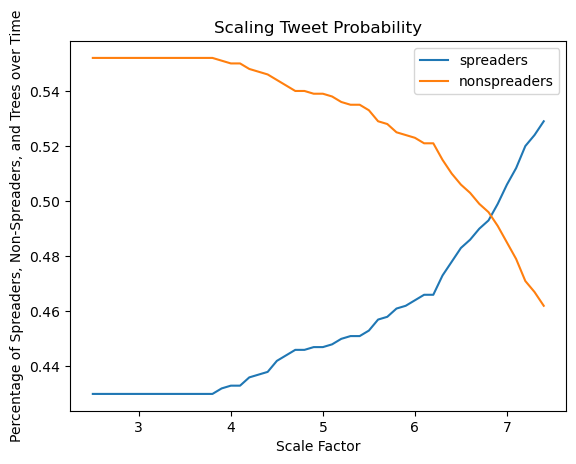

In [111]:
plt.plot(scale_factors_2,p_spreaders2, label="spreaders")
plt.plot(scale_factors_2,p_nonspreaders2, label="nonspreaders")
# plt.plot(scale_factors,trees, label="trees")

plt.xlabel('Title')
plt.ylabel('Percentage of Spreaders, Non-Spreaders, and Trees over Time')
plt.xlabel('Scale Factor')
plt.title('Scaling Tweet Probability')
plt.legend()
plt.show()

# 3D Plot

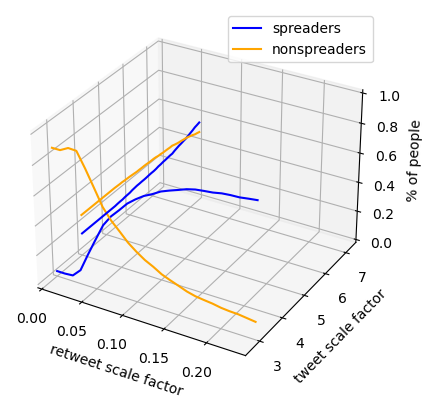

In [112]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.axes.set_xlim3d(left=scale_factors[0], right=scale_factors[-1]) # x is retweet scale factor 
ax.axes.set_ylim3d(bottom=scale_factors_2[0], top=scale_factors_2[-1]) # y is tweet scale factor 
ax.axes.set_zlim3d(bottom=0, top=1) # z is % of people 

ax.set_xlabel('retweet scale factor', rotation=150)
ax.set_ylabel("tweet scale factor")
ax.set_zlabel("% of people",rotation=60)

# PLOT first - changing retweet scale factor, tweet scale factor is 3
ax.plot3D(scale_factors, [3]*len(p_spreaders), p_spreaders, 'blue', label= 'spreaders')
ax.plot3D(scale_factors, [3]*len(p_nonspreaders), p_nonspreaders, 'orange', label= 'nonspreaders')

# second - changing tweet scale factor, retweet scale factor is 0.05
ax.plot3D([.05]*len(p_spreaders2), scale_factors_2, p_spreaders2,  'blue')
ax.plot3D([.05]*len(p_nonspreaders2),scale_factors_2, p_nonspreaders2, 'orange')

ax.legend()


In [ ]:
from mpl_toolkits import mplot3d

fig2 = plt.figure()
ax2 = plt.axes(projection ='3d')
ax2.axes.set_xlim3d(left=scale_factors[0], right=scale_factors[-1]) # x is retweet scale factor 
ax2.axes.set_ylim3d(bottom=scale_factors_2[0], top=scale_factors_2[-1]) # y is tweet scale factor 
ax2.axes.set_zlim3d(bottom=0, top=1) # z is % of people 

ax2.set_xlabel('retweet scale factor', rotation=150)
ax2.set_ylabel("tweet scale factor")
ax2.set_zlabel("% of people",rotation=60)

# PLOT first - changing retweet scale factor, tweet scale factor is 3
ax2.plot3D(scale_factors, [3]*len(p_spreaders), p_spreaders, 'blue', label= 'spreaders')
ax2.plot3D(scale_factors, [3]*len(p_nonspreaders), p_nonspreaders, 'orange', label= 'nonspreaders')

# second - changing tweet scale factor, retweet scale factor is 0.05
ax2.plot3D([.05]*len(p_spreaders2), scale_factors_2, p_spreaders2,  'blue')
ax2.plot3D([.05]*len(p_nonspreaders2),scale_factors_2, p_nonspreaders2, 'orange')
ax2.view_init(30, 120)

ax2.legend()


In [117]:
# Same code as above, to scale tweet and retweet probability in different combinations
p_spreaders3 = []
p_nonspreaders3 = []
trees3 = []

for sf1 in scale_factors:
    # regenerate retweet probs
    r_u_scaled, r_u_sigmoid_scaled = scale_retweet_probs(sf1, r_u_init, r_u_sigmoid_init)
    p_spreaders = [] 
    p_nonspreaders = []
    trees = [] 
    
    for sf2 in scale_factors_2: 

        # regenerate tweet probs
        f_u_scaled, f_u_sigmoid_scaled = scale_tweet_probs(sf2,f_u_init_2,f_u_sigmoid_init_2)
        # print('F_U_SIGMOID: ', f_u_sigmoid_scaled)

        # RUN 
        r_0 = 0.5
        f_0 = 0.5
        lists = mff(G1,f_u_sigmoid_scaled,r_u_sigmoid_scaled,f_0,r_0)
        S = lists[0]
        N = lists[1]
        num_S = lists[2]
        num_N = lists[3]
        num_T = lists[4]

    #     print(num_S)

        N_checkpoints = lists[6]
        S_checkpoints = lists[7]

        iterations = lists[5]
        p_s = (num_S[-1])/(numNodes)
        p_ns = (num_N[-1])/(numNodes)
        p_spreaders.append(p_s)
        p_nonspreaders.append(p_ns)
        trees.append(1-(p_s+p_ns))
        
    p_spreaders3.append(p_spreaders)
    p_nonspreaders3.append(p_nonspreaders)
    trees2.append(trees)

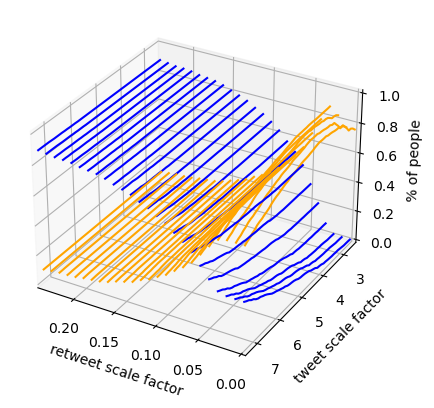

In [122]:
from mpl_toolkits import mplot3d

fig3 = plt.figure()
ax3 = plt.axes(projection ='3d')
ax3.axes.set_xlim3d(left=scale_factors[0], right=scale_factors[-1]) # x is retweet scale factor 
ax3.axes.set_ylim3d(bottom=scale_factors_2[0], top=scale_factors_2[-1]) # y is tweet scale factor 
ax3.axes.set_zlim3d(bottom=0, top=1) # z is % of people 

ax3.set_xlabel('retweet scale factor', rotation=150)
ax3.set_ylabel("tweet scale factor")
ax3.set_zlabel("% of people",rotation=60)

for i in range(len(p_spreaders3)):
    # i - retweet probability 
    # j - tweet probability 
    
    # grab this retweet prob 
    r_prob_scale = scale_factors[i] 
    
    ax3.plot3D([r_prob_scale]*len(p_spreaders3[i]), scale_factors_2,  p_spreaders3[i], 'blue')
    ax3.plot3D([r_prob_scale]*len(p_spreaders3[i]), scale_factors_2,  p_nonspreaders3[i], 'orange')


ax3.view_init(30, 120)

In [125]:
tweet_scale_factors_test = list(np.arange(2.5, 7.5, 0.2))
print(len(tweet_scale_factors_test))

25


In [126]:
p_spreaders4 = []
p_nonspreaders4 = []
trees4 = []
    
for sf1 in scale_factors:
    # regenerate retweet probs
    r_u_scaled, r_u_sigmoid_scaled = scale_retweet_probs(sf1, r_u_init, r_u_sigmoid_init)
    p_spreaders = [] 
    p_nonspreaders = []
    trees = [] 
    
    for sf2 in tweet_scale_factors_test: 

        # regenerate tweet probs
        f_u_scaled, f_u_sigmoid_scaled = scale_tweet_probs(sf2,f_u_init_2,f_u_sigmoid_init_2)
        # print('F_U_SIGMOID: ', f_u_sigmoid_scaled)

        # RUN 
        r_0 = 0.5
        f_0 = 0.5
        lists = mff(G1,f_u_sigmoid_scaled,r_u_sigmoid_scaled,f_0,r_0)
        S = lists[0]
        N = lists[1]
        num_S = lists[2]
        num_N = lists[3]
        num_T = lists[4]

    #     print(num_S)

        N_checkpoints = lists[6]
        S_checkpoints = lists[7]

        iterations = lists[5]
        p_s = (num_S[-1])/(numNodes)
        p_ns = (num_N[-1])/(numNodes)
        p_spreaders.append(p_s)
        p_nonspreaders.append(p_ns)
        trees.append(1-(p_s+p_ns))
        
    p_spreaders4.append(p_spreaders)
    p_nonspreaders4.append(p_nonspreaders)
    trees4.append(trees)

(25, 25)
(25, 25)
(25, 25)


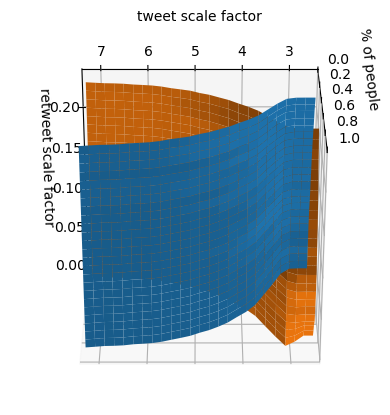

In [127]:
fig4 = plt.figure()
ax4 = plt.axes(projection ='3d')
ax4.axes.set_xlim3d(left=scale_factors[0], right=scale_factors[-1]) # x is retweet scale factor 
ax4.axes.set_ylim3d(bottom=tweet_scale_factors_test[0], top=tweet_scale_factors_test[-1]) # y is tweet scale factor 
ax4.axes.set_zlim3d(bottom=0, top=1) # z is % of people 

ax4.set_xlabel('retweet scale factor', rotation=150)
ax4.set_ylabel("tweet scale factor")
ax4.set_zlabel("% of people",rotation=60)

X = numpy.asarray(scale_factors)
Y = numpy.asarray(tweet_scale_factors_test)
X, Y = np.meshgrid(X,Y)

Z1 = numpy.asarray(p_spreaders4)
Z2 = numpy.asarray(p_nonspreaders4)

#print(X)
#print(Z1)
print(X.shape)
print(Y.shape)
print(Z1.shape)

surf = ax4.plot_surface(X, Y,  Z1)
surf2 = ax4.plot_surface(X, Y,  Z2)

# 15, 150
ax4.view_init(120, 180)

plt.show()

# Checkpoint Graph visualization

In [128]:
# Define graph 
numNodes_small = 30
p_small = 0.15
averageDeg_small = numNodes_small*p_small
totalDegSum_small= total_degree_sum(p_small,numNodes_small)

degree_small = createRandomDist(numNodes_small, averageDeg_small,totalDegSum_small)
in_degrees_small = degree_small[0]
out_degrees_small = degree_small[1]

In [129]:
G_small = nx.directed_configuration_model(in_degree_sequence = in_degrees_small,out_degree_sequence = out_degrees_small)
G_small.remove_edges_from(nx.selfloop_edges(G_small)) # remove self-loops 

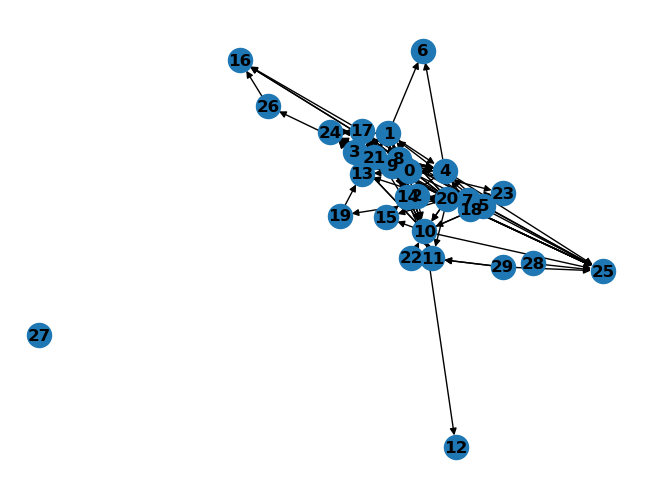

In [130]:
nx.draw(G_small,with_labels=True,font_weight='bold')
plt.show()

In [131]:
# Compute all user activities and topic significance for  graph
UA_small = {}
for node in G_small.nodes: 
    UA_small[node] = UserActivity(G1,node)
    
TS_small = 1

In [133]:
# Compute tweet probabilities
f_u_init_small = {}
f_u_sigmoid_init_small = {}
scale_factor_small = 3

for node in G_small.nodes: 
    # compute f_u 
    f =  compute_tweet_prob(G_small,TS_small,UA_small[node],scale_factor_small)
    f_u_init_small[node]=f
    f_u_sigmoid_init_small[node] = sigmoid(f)

In [135]:
# Compute retweet probabilites
r_u_init_small = {}
r_u_sigmoid_init_small = {}
scale_factor_small = 0.05

for node in G_small.nodes: 
    
    # loop through followers of this node 
    for follower in G_small.predecessors(node):
        r = compute_retweet_prob(G_small,node,follower,scale_factor_small,TS_small,UA_small[node])
        r_u_init_small[(node,follower)] = r
        r_u_sigmoid_init_small[(node,follower)] = sigmoid(r)

In [136]:
# Run simulation new small graph 

# Define thresholds 
r_0_small = 0.5
f_0_small = 0.5

lists_small = mff(G1,f_u_sigmoid_init,r_u_sigmoid_scaled,f_0,r_0)

S_small = lists[0]
N_small = lists[1]
num_S_small = lists[2]
num_N_small = lists[3]
num_T_small = lists[4]

N_checkpoints_small = lists[6]
S_checkpoints_small = lists[7]

iterations_small = lists[5]



In [137]:
color_map1_small = []
color_map2_small = []
color_map3_small = []
color_map4_small = []
color_map5_small = []

# green - trees
# yellow - spreaders
# red - non-spreaders 

for node in G_small.nodes: 
    # FIRST CHECKPOINT
    if node in N_checkpoints_small[0]:  # non-spreader
        color_map1_small.append('red') 
    elif node in S_checkpoints[0]:   # spreader
        color_map1_small.append('yellow')
    else: 
        color_map1_small.append('green')   # unreached tree
         
    # SECOND CHECKPOINT
    if node in N_checkpoints_small[1]:  # non-spreader
        color_map2_small.append('red') 
    elif node in S_checkpoints[1]:   # spreader
        color_map2_small.append('yellow')
    else: 
        color_map2_small.append('green')   # unreached tree
        
        
    # THIRD CHECKPOINT
    if node in N_checkpoints_small[2]:  # non-spreader
        color_map3_small.append('red') 
    elif node in S_checkpoints[2]:   # spreader
        color_map3_small.append('yellow')
    else: 
        color_map3_small.append('green')   # unreached tree
        
        
    # FOURTH CHECKPOINT
    if node in N_checkpoints_small[3]:  # non-spreader
        color_map4_small.append('red') 
    elif node in S_checkpoints[3]:   # spreader
        color_map4_small.append('yellow')
    else: 
        color_map4_small.append('green')   # unreached tree
        
    # FIFTH CHECKPOINT
    if node in N_checkpoints_small[4]:  # non-spreader
        color_map5_small.append('red') 
    elif node in S_checkpoints[4]:   # spreader
        color_map5_small.append('yellow')
    else: 
        color_map5_small.append('green')   # unreached tree
        
        
        


In [138]:
my_pos = nx.spring_layout(G_small, seed = 50)


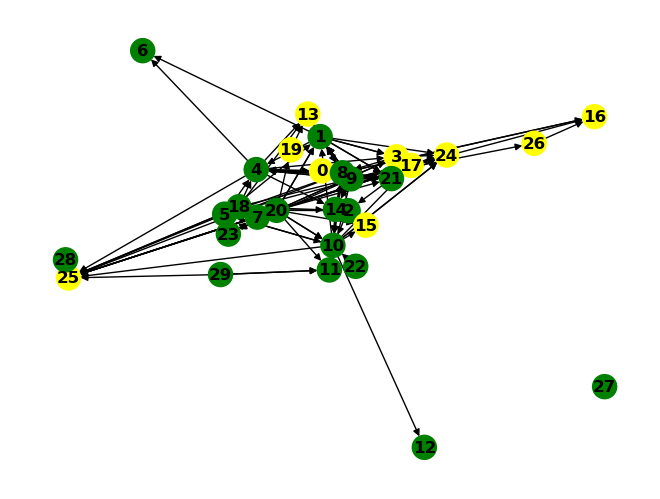

In [139]:
nx.draw(G_small,pos = my_pos,with_labels=True,node_color=color_map1_small, font_weight='bold')
plt.show()

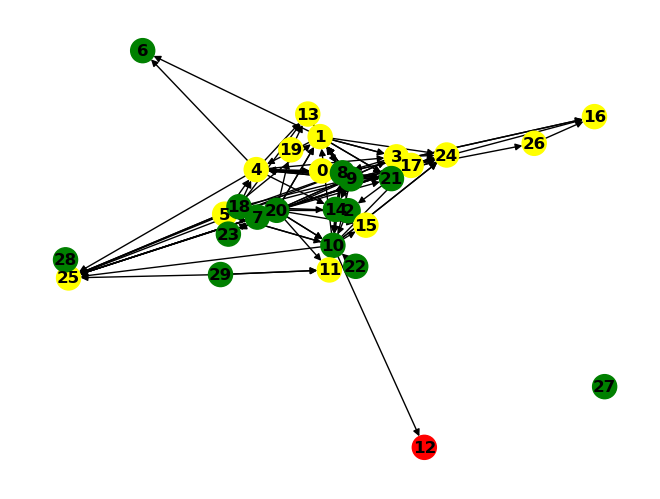

In [140]:
nx.draw(G_small,pos = my_pos,with_labels=True,node_color=color_map2_small, font_weight='bold')
plt.show()

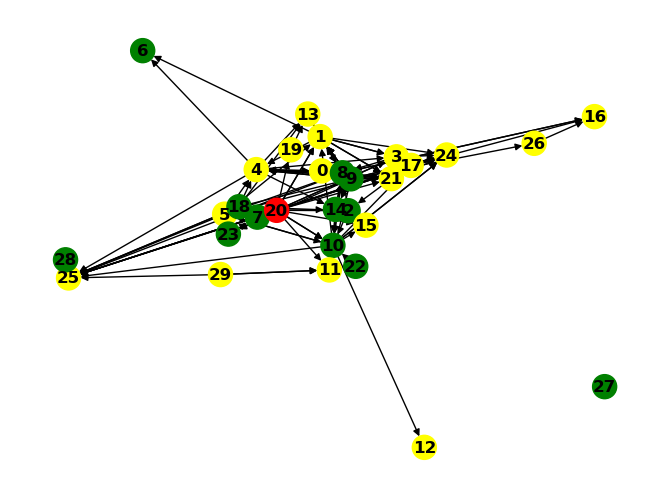

In [141]:
nx.draw(G_small,pos = my_pos,with_labels=True,node_color=color_map3_small, font_weight='bold')
plt.show()

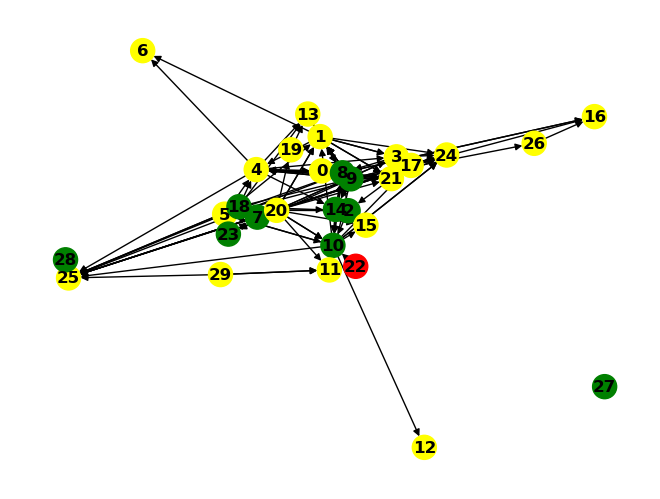

In [142]:
nx.draw(G_small,pos = my_pos,with_labels=True,node_color=color_map4_small, font_weight='bold')
plt.show()

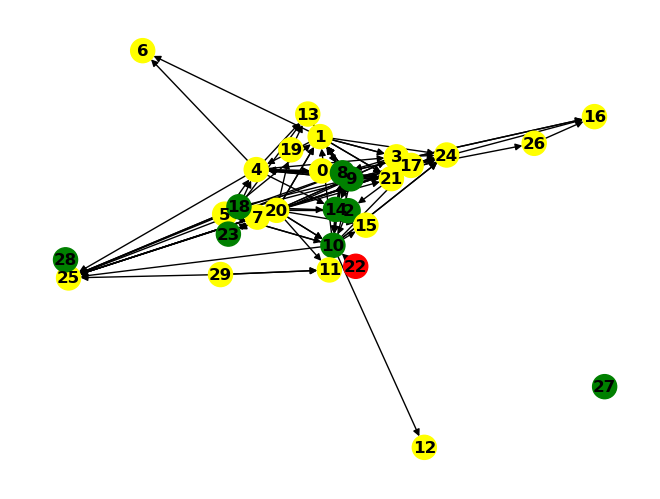

In [143]:
nx.draw(G_small,pos = my_pos,with_labels=True,node_color=color_map5_small, font_weight='bold')
plt.show()